***Mount Google Drive & verify files***

In [1]:
# Step 1: mount and verify where files are
from google.colab import drive
drive.mount('/content/drive')

import os
path = "/content/drive/MyDrive/mnist"   # <-- change if your mnist folder is elsewhere
print("Listing", path)
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  - {f}")


Mounted at /content/drive
Listing /content/drive/MyDrive/mnist
mnist/
  - t10k-labels.idx1-ubyte
  - train-labels.idx1-ubyte
  - t10k-images.idx3-ubyte
  - train-images.idx3-ubyte
  - mnist_best_model.h5
  - mnist_final_model.h5
  t10k-labels-idx1-ubyte/
    - t10k-labels-idx1-ubyte
  t10k-images-idx3-ubyte/
    - t10k-images-idx3-ubyte
  train-images-idx3-ubyte/
    - train-images-idx3-ubyte
  train-labels-idx1-ubyte/
    - train-labels-idx1-ubyte


***Helper functions: read IDX format (images & labels)***

In [2]:
# Step 2: IDX loader (no external dependency)
import struct
import numpy as np

def read_idx_labels(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError("Not a label file (magic != 2049): " + path)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        if data.size != n:
            raise ValueError(f"Label count mismatch: expected {n}, got {data.size}")
        return data

def read_idx_images(path):
    with open(path, 'rb') as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError("Not an image file (magic != 2051): " + path)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(n, rows, cols)
        return data


***Paths to your files and loading data***

In [3]:
# Step 3: set exact file paths based on your listing
base = "/content/drive/MyDrive/mnist"

train_images_path = os.path.join(base, "train-images.idx3-ubyte")
train_labels_path = os.path.join(base, "train-labels.idx1-ubyte")
test_images_path  = os.path.join(base, "t10k-images.idx3-ubyte")
test_labels_path  = os.path.join(base, "t10k-labels.idx1-ubyte")

# If your Drive contains the alternative folders (train-images-idx3-ubyte/train-images-idx3-ubyte etc),
# you could switch to those files by adjusting the paths above.

# Load
X_train = read_idx_images(train_images_path)
y_train = read_idx_labels(train_labels_path)
X_test  = read_idx_images(test_images_path)
y_test  = read_idx_labels(test_labels_path)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


***Preprocess (normalize, reshape) and train/val split***

In [4]:
# Step 4: preprocess
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Normalize to [0,1]
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

# Add channel dimension for Keras (N,28,28,1)
X_train = X_train[..., None]
X_test  = X_test[..., None]

# Train / validation split (keep some val data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print("After split:", X_train.shape, X_val.shape, X_test.shape)


After split: (54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


***Build a clean CNN model (good baseline)***

In [5]:
# Step 5: define CNN
from tensorflow.keras import layers, models, callbacks

def make_model():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = make_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,906 (3.42 MB)

 Trainable params: 896,906 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

***Train the model (with callbacks)***

In [6]:
# Step 6: training
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
ckpt_path = "/content/drive/MyDrive/mnist/mnist_best_model.h5"  # will save to your Drive
mc = callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[es, mc]
)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8418 - loss: 0.4881

422/422 ━━━━━━━━━━━━━━━━━━━━ 100s 231ms/step - accuracy: 0.8420 - loss: 0.4874 - val_accuracy: 0.9833 - val_loss: 0.0631
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9806 - loss: 0.0656

422/422 ━━━━━━━━━━━━━━━━━━━━ 139s 225ms/step - accuracy: 0.9806 - loss: 0.0656 - val_accuracy: 0.9877 - val_loss: 0.0475
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9865 - loss: 0.0453

422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 226ms/step - accuracy: 0.9865 - loss: 0.0453 - val_accuracy: 0.9883 - val_loss: 0.0383
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9896 - loss: 0.0347 - val_accuracy: 0.9890 - val_loss: 0.0439
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9923 - loss: 0.0254

422/422 ━━━━━━━━━━━━━━━━━━━━ 145s 234ms/step - accuracy: 0.9923 - loss: 0.0254 - val_accuracy: 0.9913 - val_loss: 0.0323
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 95s 225ms/step - accuracy: 0.9931 - loss: 0.0215 - val_accuracy: 0.9887 - val_loss: 0.0467
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 99s 234ms/step - accuracy: 0.9935 - loss: 0.0199 - val_accuracy: 0.9890 - val_loss: 0.0402
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 139s 226ms/step - accuracy: 0.9954 - loss: 0.0143 - val_accuracy: 0.9887 - val_loss: 0.0435
Epoch 9/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 140s 223ms/step - accuracy: 0.9957 - loss: 0.0149 - val_accuracy: 0.9885 - val_loss: 0.0466
Epoch 10/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 95s 226ms/step - accuracy: 0.9961 - loss: 0.0110 - val_accuracy: 0.9893 - val_loss: 0.0398


***Evaluate on test set, confusion matrix, show misclassified examples***

Test accuracy: 0.9921, Test loss: 0.0226
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step


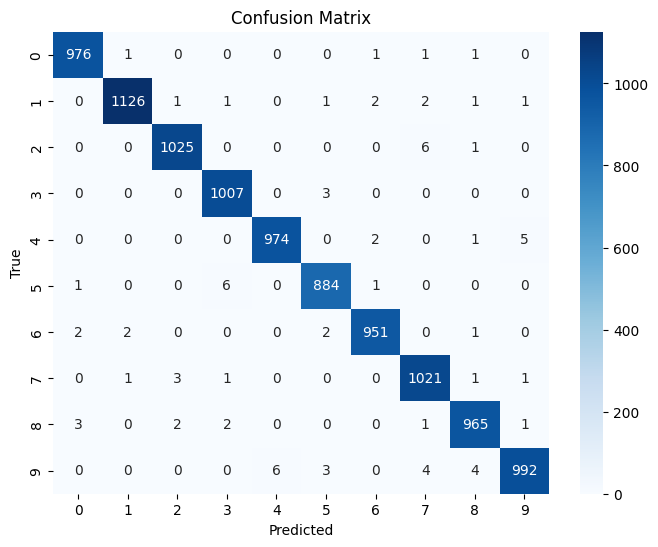

              precision    recall  f1-score   support

           0     0.9939    0.9959    0.9949       980
           1     0.9965    0.9921    0.9943      1135
           2     0.9942    0.9932    0.9937      1032
           3     0.9902    0.9970    0.9936      1010
           4     0.9939    0.9919    0.9929       982
           5     0.9899    0.9910    0.9905       892
           6     0.9937    0.9927    0.9932       958
           7     0.9865    0.9932    0.9898      1028
           8     0.9897    0.9908    0.9903       974
           9     0.9920    0.9832    0.9876      1009

    accuracy                         0.9921     10000
   macro avg     0.9920    0.9921    0.9921     10000
weighted avg     0.9921    0.9921    0.9921     10000

Total misclassified: 79


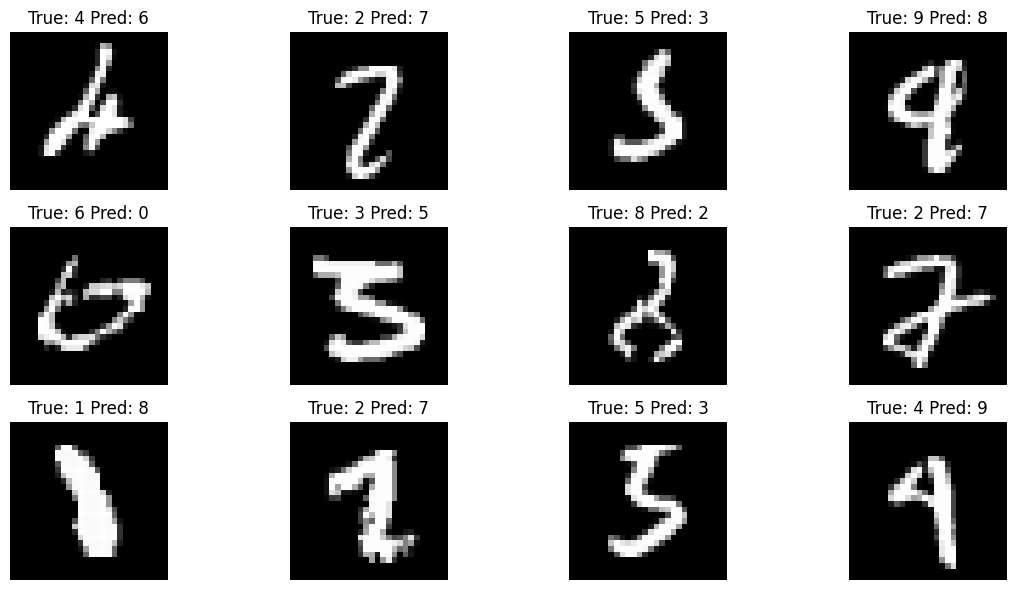

In [7]:
# Step 7: evaluation + visuals
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, digits=4))

# Show some misclassified examples
mis_idx = np.where(y_pred != y_test)[0]
print("Total misclassified:", len(mis_idx))
N = 12
plt.figure(figsize=(12,6))
for i, idx in enumerate(mis_idx[:N]):
    plt.subplot(3,4,i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[idx]} Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


***Save final model and example predictions CSV (for submission)***

In [8]:
# Step 8: save final model (already saved best checkpoint), optionally save a CSV of predictions
final_model_path = "/content/drive/MyDrive/mnist/mnist_final_model.h5"
model.save(final_model_path)
print("Saved model to:", final_model_path)

# Example: save a small csv of first 100 test preds
import pandas as pd
df = pd.DataFrame({
    'index': np.arange(len(y_test))[:100],
    'true': y_test[:100],
    'pred': y_pred[:100],
})
csv_path = "/content/drive/MyDrive/mnist/mnist_test_preds_sample.csv"
df.to_csv(csv_path, index=False)
print("Saved sample predictions to:", csv_path)


Saved model to: /content/drive/MyDrive/mnist/mnist_final_model.h5
Saved sample predictions to: /content/drive/MyDrive/mnist/mnist_test_preds_sample.csv
